In [3]:
import math
import random

In [4]:
class NeuralNetwork(object):

    def __init__(self, learning_rate=0.5, debug=False):
        """
        Train NeuralNetwork by fixed learning rate
        """
        self.neuron_layers = []
        self.learning_rate = learning_rate
        self.debug = debug

    def train(self, dataset):
        for inputs, outputs in dataset:
            self.feed_forward(inputs)
            self.feed_backword(outputs)
            self.update_weights(self.learning_rate)

    def feed_forward(self, inputs):
        s = inputs
        for (i, l) in enumerate(self.neuron_layers):
            s = l.feed_forward(s)
            if self.debug:
                print ("Layer %s:" % (i+1), " output:%s" % s)
        return s

    def feed_backword(self, outputs):
        layer_num = len(self.neuron_layers)
        l = layer_num
        previous_deltas = [] 
        while l != 0:
            current_layer = self.neuron_layers[l - 1]
            if len(previous_deltas) == 0:
                for i in range(len(current_layer.neurons)):
                    error = -(outputs[i] - current_layer.neurons[i].output)
                    current_layer.neurons[i].calculate_delta(error)
            else:
                previous_layer = self.neuron_layers[l]
                for i in range(len(current_layer.neurons)):
                    error = 0
                    for j in range(len(previous_deltas)):
                        error += previous_deltas[j] * previous_layer.neurons[j].weights[i]
                    current_layer.neurons[i].calculate_delta(error)
            previous_deltas = current_layer.get_deltas()
            if self.debug:
                print ("Layer %s:" % l, "deltas:%s" % previous_deltas)
            l -= 1

    def update_weights(self, learning_rate):
        for l in self.neuron_layers:
            l.update_weights(learning_rate)

    def calculate_total_error(self, dataset):
        """
        Return mean squared error of dataset
        """
        total_error = 0
        for inputs, outputs in dataset:
            actual_outputs = self.feed_forward(inputs)
            for i in range(len(outputs)):
                total_error += (outputs[i] - actual_outputs[i]) ** 2
        return total_error / len(dataset)

    def get_output(self, inputs):
        return self.feed_forward(inputs)

    def add_layer(self, neruon_layer):
        self.neuron_layers.append(neruon_layer)

    def dump(self):
        for (i, l) in enumerate(self.neuron_layers):
            print ("Dump layer: %s" % (i+1))
            l.dump()

In [5]:
class NeuronLayer(object):

    def __init__(self, input_num, neuron_num, init_weights=[], bias=1):
        self.neurons = []
        weight_index = 0
        for i in range(neuron_num):
            n = Neuron(input_num)
            for j in range(input_num):
                if weight_index < len(init_weights):
                    n.weights[j] = init_weights[weight_index]
                    weight_index += 1
            n.bias = bias
            self.neurons.append(n)

    def feed_forward(self, inputs):
        outputs = []
        for n in self.neurons:
            outputs.append(n.calculate_output(inputs))
        return outputs

    def get_deltas(self):
        return [n.delta for n in self.neurons]

    def update_weights(self, learning_rate):
        for n in self.neurons:
            n.update_weights(learning_rate)

    def dump(self):
        for (i, n) in enumerate(self.neurons):
            print ("-Dump neuron: %s" % (i+1))
            n.dump()

In [22]:
class Neuron(object):

    def __init__(self, weight_num):
        self.weights = []
        self.bias = 0
        self.output = 0
        self.delta = 0
        self.inputs = []
        for i in range(weight_num):
            self.weights.append(random.random())

    def calculate_output(self, inputs):
        self.inputs = inputs
        if len(inputs) != len(self.weights):
            raise Exception("Input number not fit weight number")
        self.output = 0
        for (i, w) in enumerate(self.weights):
            self.output += w * inputs[i]
        self.output = self.activation_function(self.output + self.bias)
        return self.output

    def activation_function(self, x):
        """Using sigmoid function"""
        return 1 / (1 + math.exp(-x))

    def calculate_delta(self, error):
        """ Using g' of sigmoid """
        self.delta = error * self.output * (1 - self.output)

    def update_weights(self, learning_rate):
        for (i, w) in enumerate(self.weights):
            new_w = w - learning_rate * self.delta * self.inputs[i]
            self.weights[i] = new_w
        self.bias = self.bias - learning_rate * self.delta

    def dump(self):
        print ("-- weights:", self.weights)
        print ("-- bias:", self.bias)

In [67]:
%matplotlib inline
import pandas as pd
import itertools
import numpy as np
import matplotlib.pyplot as plt

In [118]:
# Load the data into python and take a look
dataset = pd.read_csv(r'energy_efficiency_data.csv')
dataset.head()
X = dataset.iloc[:,:8].values
y = dataset.iloc[:,8:10].values

In [119]:
# switch case for Orientation and Glazing Area Distribution encode
def one_hot_encode(feature, num):
    if feature == "orientation":
        numbers = {
            2 : [1, 0, 0, 0],
            3 : [0, 1, 0, 0],
            4 : [0, 0, 1, 0],
            5 : [0, 0, 0, 1]
        }
        return numbers.get(num, None)
    else:
        numbers = {
            0 : [0, 0, 0, 0, 0],
            1 : [1, 0, 0, 0, 0],
            2 : [0, 1, 0, 0, 0],
            3 : [0, 0, 1, 0, 0],
            4 : [0, 0, 0, 1, 0],
            5 : [0, 0, 0, 0, 1]
        }
        return numbers.get(num, None)

In [120]:
# encode and normalize
tmp = []
for x in X:
    # encode
    x = x.tolist()
    x[5:5] = one_hot_encode("orientation", x[5])
    del x[9]
    x[10:10] = one_hot_encode("glazing", x[10])
    del x[15]
    # normalize
    x[1] = x[1]/810
    x[2] = x[2]/420
    x[3] = x[3]/210
    x[4] = x[4]/7
    tmp.append(x)
X = np.array(tmp)

In [123]:
# Splitting the dataset into training and testing set 75-25
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

X_train_seq, X_test_seq = X[:576,:], X[576:768,:]
y_train_seq, y_test_seq = y[:576], y[576:768]

In [130]:
dataset = []
dataset_seq = []
label_train_heating = []
label_train_cooling = []
label_test_heating = []
label_test_cooling = []
for i, j in zip(X_train.tolist(), y_train.tolist()):
    dataset.append((i, [j[0]/45]))
for i, j in zip(X_train_seq.tolist(), y_train_seq.tolist()):
    dataset_seq.append((i, [j[0]/45]))
for i in y_train_seq.tolist():
    label_train_heating.append(i[0]/45)
    label_train_cooling.append(i[1]/50)
for i in y_test_seq.tolist():
    label_test_heating.append(i[0]/45)
    label_test_cooling.append(i[1]/50)

Text(0.5,0,'#th case')

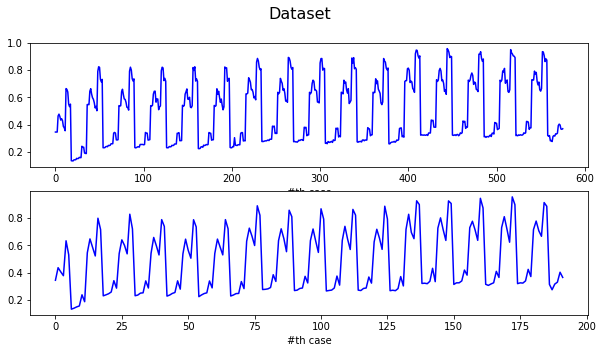

In [131]:
plt.figure(figsize=(10,5))
plt.suptitle('Dataset', fontsize=16)
plt.subplot(211)
plt.plot(range(576), label_train_heating, 'b-')
plt.xlabel('#th case')
plt.subplot(212)
plt.plot(range(192), label_test_heating, 'b-')
plt.xlabel('#th case')

In [144]:
# [(inputs, outputs)]
# dataset = [([0.3, 0.5, 0.3], [15, 30]), ([0.5, 0.3, 0.5], [30, 15])]
nn = NeuralNetwork()
hidden_layer_1 = NeuronLayer(input_num=15, neuron_num=10, bias=0.5)
hidden_layer_2 = NeuronLayer(input_num=10, neuron_num=10, bias=0.5)
output_layer = NeuronLayer(input_num=10, neuron_num=1, bias=0.6)
nn.add_layer(hidden_layer_1)
nn.add_layer(hidden_layer_2)
nn.add_layer(output_layer)
nn.dump()

tracking = []
for i in range(1000):
    nn.train(dataset)
    tracking.append(nn.calculate_total_error(dataset))

# for (i, e) in enumerate(tracking):
#     print ("%sth square total error: %s" % (i+1, e))
# print ("NeuralNetwork 2-2-2, Except output:[0, 1], Real output:%s" % nn.get_output([0.3, 0.5, 0.3]))

Dump layer: 1
-Dump neuron: 1
-- weights: [0.5843590582686208, 0.9839462211147659, 0.8902329421487973, 0.8890868497625647, 0.3193297800579137, 0.06043270567117387, 0.8107954456222796, 0.09907640584453492, 0.16916333908572956, 0.1608488592188264, 0.24563213162271547, 0.3572988768827242, 0.7001754032318483, 0.9668256408689531, 0.6908781051838816]
-- bias: 0.5
-Dump neuron: 2
-- weights: [0.11264789965174049, 0.8688930509605519, 0.3588201699141891, 0.24044668091059818, 0.7935891395679909, 0.7941052036591393, 0.29397907827542, 0.7272371332719293, 0.3087285280773575, 0.36190281965628046, 0.3376407148459355, 0.3917787905854285, 0.33181341349560356, 0.4497231356661222, 0.6715614747484282]
-- bias: 0.5
-Dump neuron: 3
-- weights: [0.7691183481337446, 0.9085871802514488, 0.5969501258895739, 0.26941888163897965, 0.02258005556961995, 0.017576237882043322, 0.36398075600557955, 0.4615075571743348, 0.21273491760552043, 0.5229323411307563, 0.6269695461978668, 0.38988960749750945, 0.34544908199118096,

In [145]:
predit_train_heating = []
predit_test_heating = []
for x in X_train_seq.tolist():
    predit_train_heating.append(nn.get_output(x))
for x in X_test_seq.tolist():
    predit_test_heating.append(nn.get_output(x))

Text(0.5,0,'#th case')

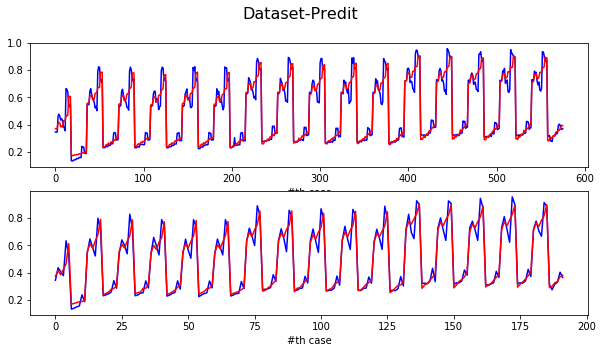

In [146]:
plt.figure(figsize=(10,5))
plt.suptitle('Dataset-Predit', fontsize=16)
plt.subplot(211)
plt.plot(range(576), label_train_heating, 'b-')
plt.plot(range(576), predit_train_heating, 'r-')
plt.xlabel('#th case')
plt.subplot(212)
plt.plot(range(192), label_test_heating, 'b-')
plt.plot(range(192), predit_test_heating, 'r-')
plt.xlabel('#th case')

In [147]:
square_error = []
for (i, e) in enumerate(tracking):
    square_error.append(e)

Text(0.5,0,'Epoch')

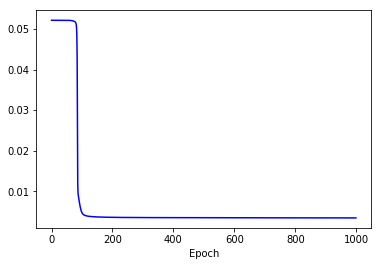

In [148]:
plt.plot(range(1000), square_error, 'b-')
plt.xlabel('Epoch')